# Breakout Strategy

In [43]:
import pandas as pd 
import yfinance as yf
import numpy as np
import sys
import os
# Add the parent directory to the sys.path
sys.path.append(os.path.join(os.path.dirname('Practice'), '..'))

from Practice import project_test2

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import plotly.graph_objects as go

import plotly.offline as offline_py
offline_py.init_notebook_mode(connected=True)


In [2]:
import yfinance as yf

tickers = ['AAPL', 'AMZN', 'IBM', 'GOOG', 'MSFT']

prices = yf.download(tickers, start="2018-01-01", end="2020-01-01")

[*********************100%%**********************]  5 of 5 completed


In [33]:
prices['Close'].iplot(xTitle='Dates',yTitle='Stock Price', title='Stock Prices')

### Compute the Highs and Lows in a Window

Using the price highs and lows as an indicator for the breakout strategy. Implement a function to get the maximum high price and minimum low price over a window of days. The variable lookback_days contains the number of days to look in the past. Make sure this doesn't include the current day.

In [4]:
def get_high_lows_lookback(high, low, lookback_days):
    """
    Get the highs and lows in a lookback window.
    Parameters
    ----------
    high : DataFrame
        High price for each ticker and date
    low : DataFrame
        Low price for each ticker and date
    lookback_days : int
        The number of days to look back
    
    Returns
    -------
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
    """
    # avoid the current date in the lookback window

    lookback_high = high.shift(1).rolling(lookback_days).max()
    lookback_low = low.shift(1).rolling(lookback_days).min()


    return lookback_high, lookback_low

# choose 50 days to lookback
lookback_days = 50

lookback_high, lookback_low = get_high_lows_lookback(prices.High, prices.Low, lookback_days)


In [34]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=lookback_high.index, y=lookback_high['AAPL'], name='Lookback High'))
fig.add_trace(go.Scatter(x=lookback_low.index, y=lookback_low['AAPL'], name='Lookback Low'))
fig.add_trace(go.Scatter(x=prices.Close.index, y=prices.Close['AAPL'], name='Close'))

fig.update_layout(title='AAPL Lookback High and Low', xaxis_title='Date', yaxis_title='Price')

### Generate Signals

We will generate signals using the lookback highs and lows computed above. 


| Signal | Condition |
|--------|-----------|
| -1     | Low > Close Price |
| 1  | High < Close Price |
| 0  | Otherwise |
    
    

In [68]:
def get_long_short(close, lookback_high, lookback_low):
    """
    Generate the signals long, short, and do nothing.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookback_high : DataFrame
        Lookback high price for each ticker and date
    lookback_low : DataFrame
        Lookback low price for each ticker and date
    
    Returns
    -------
    long_short : DataFrame
        The long, short, and do nothing signals for each ticker and date
    """
    long_short = close.copy()
    long_short[:] = 0

    long_short[lookback_high < close] = 1
    long_short[lookback_low > close] = -1
    
    
    return long_short.astype(int)

signal = get_long_short(prices.Close, lookback_high, lookback_low)

In [69]:
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode

# Initialize Plotly for offline mode within Jupyter Notebook
init_notebook_mode(connected=True)



# Example data setup
price = prices['Close']['AAPL']  # Example, assuming 'prices' DataFrame has 'Close' and 'AAPL'
signal_apl = signal['AAPL']  # Assuming 'signals' DataFrame has buy/sell signals for 'AAPL'

# Generate annotations for buy and sell signals
buy_annotations = [{'x': index, \
                    'y': price, \
                    'text': 'Long',\
                    'bgcolor':'#9dbdd5',\
                    'ayref': 'y', 'ax': 0, 'ay': 20}\
        for index, price in price[signal_apl == 1].items()]

sell_annotations = [{'x': index, \
                     'y': price, \
                    'text': 'Short',\
                    'bgcolor': '#ff6f69',\
                    'ayref': 'y', 'ax': 0, 'ay': 160}
                    for index, price in price[signal_apl == -1].items()]

# Define the title
title = 'AAPL Long and Short Signal'

# Create the layout with annotations
layout = go.Layout(
    title=title,
    annotations=buy_annotations + sell_annotations
)

# Create the stock trace
stock_trace = go.Scatter(
    x=price.index,
    y=price,
    name='AAPL',
    line={'color': '#2D3ECF'}
)

# Create the figure and plot it
fig = go.Figure(data=[stock_trace], layout=layout)
iplot(fig)


We notice multiple signals for short or buy occuring signals on consecutive days. We need to filter them out. Within the lookback window, if the previous signal was the same, change the signal to 0 (do nothing signal).

In [70]:
def clear_signals(signals, window_size):
    """
    Clear out signals in a Series of just long or short signals.
    
    Remove the number of signals down to 1 within the window size time period.
    
    Parameters
    ----------
    signals : Pandas Series
        The long, short, or do nothing signals
    window_size : int
        The number of days to have a single signal       
    
    Returns
    -------
    signals : Pandas Series
        Signals with the signals removed from the window size
    """
    # Start with buffer of window size
    # This handles the edge case of calculating past_signal in the beginning
    clean_signals = [0]*window_size
    
    for signal_i, current_signal in enumerate(signals):
        # Check if there was a signal in the past window_size of days
        has_past_signal = bool(sum(clean_signals[signal_i:signal_i+window_size]))
        # Use the current signal if there's no past signal, else 0/False
        clean_signals.append(not has_past_signal and current_signal)
        
    # Remove buffer
    clean_signals = clean_signals[window_size:]


    # Return the signals as a Series of Ints
    return pd.Series(np.array(clean_signals).astype(np.int16), signals.index)


def filter_signals(signal, lookahead_days):
    """
    Filter out signals in a DataFrame.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    filtered_signal : DataFrame
        The filtered long, short, and do nothing signals for each ticker and date
    """
    
    # Divide the signal into positive and negative
    positive_signals = signal.where(signal==1, 0)
    negative_signals = signal.where(signal==-1, 0)
    
    for col in signal.columns:
        positive_signals[col] = clear_signals(positive_signals[col], lookahead_days)
        negative_signals[col] = clear_signals(negative_signals[col], lookahead_days)
        
    filtered_signal = positive_signals + negative_signals
        
    return filtered_signal.astype(np.int64)

signal_5 = filter_signals(signal, 5)
signal_10 = filter_signals(signal, 10)
signal_20 = filter_signals(signal, 20)


In [88]:
# plot the signals

def buy_signal_layout(price, signali):
    return [{'x': index, \
                    'y': price, \
                    'text': 'Long',\
                    'bgcolor':'#9dbdd5',\
                    'ayref': 'y', 'ax': 0, 'ay': 20}\
        for index, price in price[signali == 1].items()]

def sell_signal_layout(price, signali):
    return [{'x': index, \
                     'y': price, \
                    'text': 'Short',\
                    'bgcolor': '#ff6f69',\
                    'ayref': 'y', 'ax': 0, 'ay': 160}
                    for index, price in price[signali == -1].items()]


def plot_signal(price, signal, title):
    buy_annotations = buy_signal_layout(price, signal)
    sell_annotations = sell_signal_layout(price, signal)

    layout = go.Layout(
        title=title,
        annotations=buy_annotations + sell_annotations)

    stock_trace = go.Scatter(
        x=price.index,
        y=price,
        name='AAPL',
        line={'color': '#2D3ECF'}
    )

    offline_py.iplot({'data': [stock_trace], 'layout': layout})

close = prices.Close
apple_ticker = 'AAPL'
signal_5 = filter_signals(signal, 5)
signal_10 = filter_signals(signal, 10)
signal_20 = filter_signals(signal, 20)

for signal_data, signal_days in [(signal_5, 5), (signal_10, 10), (signal_20, 20)]:
    plot_signal(
        close[apple_ticker],
        signal_data[apple_ticker],
        'Long and Short of {} Stock with {} day signal window'.format(apple_ticker, signal_days))



Now, the signals are filtered out and are non repeating.

## Lookahead Close Prices

With the trading signal done, we can start working on evaluating how many days to short or long the stocks. We can get the price at a day in future for a trade we executed to get us the returns. 

In [89]:
def get_lookahead_prices(close, lookahead_days):
    """
    Get the lookahead prices for `lookahead_days` number of days.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_days : int
        The number of days to look ahead
    
    Returns
    -------
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    """
    # get price at the end of the lookhead_days
    lookahead_prices = close.shift(-lookahead_days)
    
    return lookahead_prices

lookahead_days = 5
lookahead_prices_5 = get_lookahead_prices(prices.Close, lookahead_days)

lookahead_days = 10
lookahead_prices_10 = get_lookahead_prices(prices.Close, lookahead_days)

lookahead_days = 20
lookahead_prices_20 = get_lookahead_prices(prices.Close, lookahead_days)


In [92]:
def plot_lookahead_prices(prices, lookahead_prices_list, title):
    
    layout = go.Layout(title=title)
    
    traces = []
    for lookahead_prices,days in lookahead_prices_list:
        traces.append(
            go.Scatter(
                x=lookahead_prices.index,
                y=lookahead_prices,
                name='{} Day Lookahead'.format(days)))
        
    traces.append(
        go.Scatter(
            x=prices.index,
            y=prices,
            name='AAPL'))


    offline_py.iplot({'data': traces, 'layout': layout})


lookahead_5 = get_lookahead_prices(close, 5)
lookahead_10 = get_lookahead_prices(close, 10)
lookahead_20 = get_lookahead_prices(close, 20)


plot_lookahead_prices(
    close[apple_ticker].iloc[150:250],
    [
        (lookahead_5[apple_ticker].iloc[150:250], 5),
        (lookahead_10[apple_ticker].iloc[150:250], 10),
        (lookahead_20[apple_ticker].iloc[150:250], 20)],
    '5, 10, and 20 day Lookahead Prices for Slice of {} Stock'.format(apple_ticker))

### Lookahead Returns

We can get the returns from the lookahead prices.

In [93]:
def get_return_lookahead(close, lookahead_prices):
    """
    Calculate the log returns from the lookahead days to the signal day.
    
    Parameters
    ----------
    close : DataFrame
        Close price for each ticker and date
    lookahead_prices : DataFrame
        The lookahead prices for each ticker and date
    
    Returns
    -------
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    """
    lookahead_returns = np.log(lookahead_prices/close)
    
    return lookahead_returns
    

lookahead_returns_5 = get_return_lookahead(prices.Close, lookahead_prices_5)
lookahead_returns_10 = get_return_lookahead(prices.Close, lookahead_prices_10)
lookahead_returns_20 = get_return_lookahead(prices.Close, lookahead_prices_20)

In [97]:
def plot_lookahead_returns(prices, lookahead_returns_list, title):
    
    layout = go.Layout(title=title)
    
    traces = []
    for lookahead_returns,days in lookahead_returns_list:
        traces.append(
            go.Scatter(
                x=lookahead_returns.index,
                y=lookahead_returns,
                name='{} Day Lookahead'.format(days)))
        

    offline_py.iplot({'data': traces, 'layout': layout})

plot_lookahead_returns(
    close[apple_ticker].iloc[150:250],
    [
        (lookahead_returns_5[apple_ticker].iloc[150:250], 5),
        (lookahead_returns_10[apple_ticker].iloc[150:250], 10),
        (lookahead_returns_20[apple_ticker].iloc[150:250], 20)],
    '5, 10, and 20 day Lookahead Returns for Slice {} Stock'.format(apple_ticker))

### Signal Returns

Now we can get the returns due to the trading signal.

In [98]:
def get_signal_return(signal, lookahead_returns):
    """
    Compute the signal returns.
    
    Parameters
    ----------
    signal : DataFrame
        The long, short, and do nothing signals for each ticker and date
    lookahead_returns : DataFrame
        The lookahead log returns for each ticker and date
    
    Returns
    -------
    signal_return : DataFrame
        Signal returns for each ticker and date
    """
    signal_return = signal * lookahead_returns
    
    
    return signal_return


signal_return_5 = get_signal_return(signal_5, lookahead_returns_5)
signal_return_10 = get_signal_return(signal_10, lookahead_returns_10)
signal_return_20 = get_signal_return(signal_20, lookahead_returns_20)

In [107]:
def plot_signal_returns(price,signal_return_list, titles):
    
    layout = go.Layout(
        yaxis2={
            'title': 'Signal Returns',
            'overlaying': 'y',
            'side': 'right'},yaxis={'title': 'Stock Price'})
    
    stock_trace = go.Scatter(x=price.index, y=price, name='AAPL')
    
    for (signal_return, signal, lookahead_days), title in zip(signal_return_list, titles):
        non_zero_signals = signal_return[signal_return != 0]
        signal_return_trace = go.Scatter(
                x=non_zero_signals.index,
                y=non_zero_signals,
                name='{} Day Lookahead'.format(lookahead_days),
                yaxis='y2')

        buy_annotations = buy_signal_layout(price, signal)
        sell_annotations = sell_signal_layout(price, signal)

        layout['title'] = title
        layout['annotations'] = buy_annotations + sell_annotations

        offline_py.iplot({'data': [stock_trace, signal_return_trace], 'layout': layout})



title_string ='Returns with {} day signal window for {} stock'
plot_signal_returns(
    close[apple_ticker],
    [
        (signal_return_5[apple_ticker], signal_5[apple_ticker], 5),
        (signal_return_10[apple_ticker], signal_10[apple_ticker], 10),
        (signal_return_20[apple_ticker], signal_20[apple_ticker], 20)],
    [title_string.format(5, apple_ticker), title_string.format(10, apple_ticker), title_string.format(20, apple_ticker)])

### Test for significance

Histogram of the signal returns

In [113]:
from plotly.subplots import make_subplots

def plot_signal_histograms(signal_list, title, subplot_titles):
    
    stacked_list =  [signal.stack() for signal in signal_list]


    fig = make_subplots(rows=1, cols=len(stacked_list), subplot_titles=subplot_titles, print_grid=False)
    fig['layout'].update(title=title, showlegend=False)

    for series_i, signal_series in enumerate(stacked_list):
        filtered_series = signal_series[signal_series != 0].dropna()
        trace = go.Histogram(x=filtered_series)
        fig.append_trace(trace,1,series_i+1)
        
    offline_py.iplot(fig)


plot_signal_histograms(
    [signal_5, signal_10, signal_20],
    'Signals for {} Stock'.format(apple_ticker),
    ['5 Day Signal', '10 Day Signal', '20 Day Signal'])



0
1
2


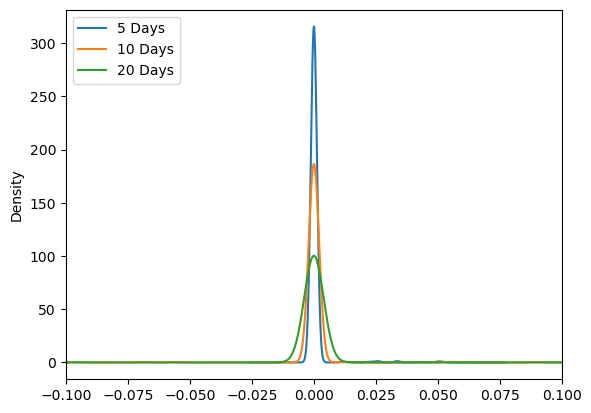

In [ ]:
# plot the signal returns

fig,ax = plt.subplots(1,1)
signal_return_5['AAPL'].plot(kind='kde', label='5 Days')
signal_return_10['AAPL'].plot(kind='kde',label='10 Days')
signal_return_20['AAPL'].plot(kind='kde',label='20 Days')
ax.set_xlim(-0.1,0.1)
ax.legend(loc='upper left')